# Kaggle's Digit Recognizer challange

In [1]:
import pandas as pd
import numpy as np
import keras.layers as L
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils


%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 10)  

Using Theano backend.


Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: GeForce GTX 970 (CNMeM is disabled, CuDNN 4007)


Let's load the data and print out some information about the data

In [2]:
#this notebook should be executed from the same folder, where the data is stored. if not: change path here
train = pd.read_csv('train.csv').values
test = pd.read_csv('test.csv').values

print 'Shape of the training data: ' + str(train.shape)
print 'Shape of the test data: ' + str(test.shape)
print 'Datatype: ' + str(train.dtype)

Shape of the training data: (42000, 785)
Shape of the test data: (28000, 784)
Datatype: int64


First Number of each tuple is the number of training/test-images. The images are of size 28px x 28px = 784px
As mentioned on the kaggle page, the first entry of the training data in each sample is the label. As we would like to use a convolutional network we need to reshape the data and bring the labels to categorical matrices ( = one-hot vector per image). Also we would like to have floating point numbers, so lets first do some data preprocessing.

In [3]:
num_rows, num_cols = 28, 28

#reshape training data to (num_samples, channels, num_rows, num_cols) = (42000,1,28,28)
x_train = train[:, 1:].reshape(train.shape[0], 1, num_rows, num_cols)
x_train = x_train.astype(np.float32)
x_train /= 255.0 #convert values from "0 to 255" to "0 to 1"

#do the same with the test data
x_test = test.reshape(test.shape[0], 1, num_cols, num_rows)
x_test = x_test.astype(np.float32)
x_test /= 255.0

#get training label and convert to one-hot array
y_train = np_utils.to_categorical(train[:,0])
num_classes = y_train.shape[1]

As I think it's always good to actually visualize some of the data, let's see some random training images.

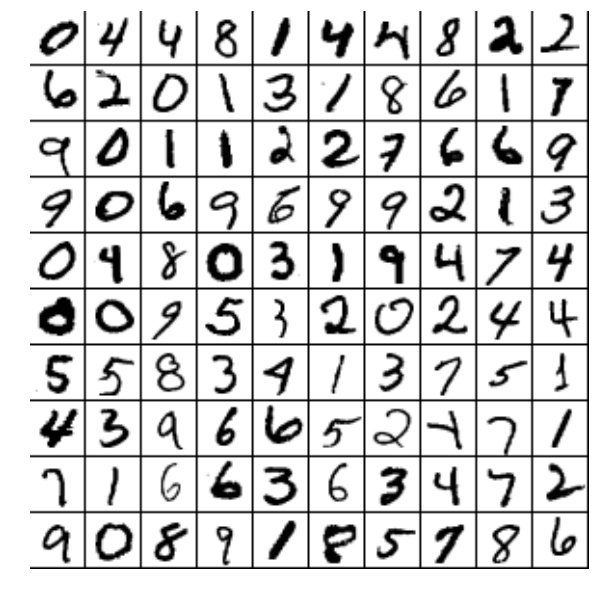

In [4]:
#helper function to visualize mnist training samples
def viz_mnist(data):
    
    n = int(np.ceil(np.sqrt(data.shape[0])))
    data = data.reshape((data.shape[0],data.shape[2], data.shape[3]))
    
    #add some padding between images 
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1)))
    
    data = np.pad(data, padding, mode='constant', constant_values=1)
    
    #reshape data into one big image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3))
    data = data.reshape((n * data.shape[1], n * data.shape[3]))
    
    plt.imshow(data, cmap='binary'); plt.axis('off')

#get some random index values of the training set   
idx = np.random.randint(0, train.shape[0], (100,))
data = x_train[idx,:,:,:]

#visualize the random samples
viz_mnist(data)


Okay, let's set up the model. There are a lot of hyperparameters here, that you can change as you like. All tuneable parameters are at the top of the code box.

In [12]:
### TUNEABLE PARAMETERS ###

# number of conv layer
nb_conv = 5
# list of numbers of filter for each conv layer (same number of values as nb_conv)
nb_filters = [64,128,128,128,256]
# size of pooling area for max pooling
pool_sz = 2
# convolution kernel size
filter_sz = 3
#size of batch per iteration
batch_size = 128
#number of epoches used for training
nb_epoch = 100

#number of dense layer (excluding softmax layer)
nb_dense = 1
#list of number of neuros in the dense layer
nb_neurons = [256]

#percentage of dropout for dense layer
drpt_rate = 0.25



### END OF TUNABLE PARAMETERS ###

#number of classes
nb_classes = 10

#Model initialization
model = Sequential()

#add first conv layer and pass input size 
model.add(Convolution2D(nb_filters[0], filter_sz, filter_sz,
                        border_mode='valid',
                        input_shape=(1, num_rows, num_cols)))
model.add(Activation('relu'))

#add all remaining conv layer
for i in range(nb_conv - 1):
    
    model.add(Convolution2D(nb_filters[i+1], filter_sz, filter_sz))
    model.add(Activation('relu'))
    
    #add maxpooling only every second conv layer
    if (i+1)%2 == 0:
        model.add(MaxPooling2D(pool_size=(pool_sz, pool_sz)))

#flatten activation maps to vector
model.add(Flatten())

#add all dense layer (excl. softmax)
for i in range(nb_dense):
    
    model.add(Dense(nb_neurons[i]))
    model.add(Activation('relu'))
    model.add(Dropout(drpt_rate))

#add softmax layer
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

#print model summary
model.summary()

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
convolution2d_21 (Convolution2D)   (None, 64, 26, 26)  640         convolution2d_input_6[0][0]      
____________________________________________________________________________________________________
activation_33 (Activation)         (None, 64, 26, 26)  0           convolution2d_21[0][0]           
____________________________________________________________________________________________________
convolution2d_22 (Convolution2D)   (None, 128, 24, 24) 73856       activation_33[0][0]              
____________________________________________________________________________________________________
activation_34 (Activation)         (None, 128, 24, 24) 0           convolution2d_22[0][0]           
___________________________________________________________________________________________

In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=1)

Epoch 1/100
42000/42000 [==============================] - 25s - loss: 0.0542 - acc: 0.9837    
Epoch 2/100
42000/42000 [==============================] - 25s - loss: 0.0335 - acc: 0.9898    
Epoch 3/100
42000/42000 [==============================] - 25s - loss: 0.0247 - acc: 0.9925    
Epoch 4/100
42000/42000 [==============================] - 25s - loss: 0.0180 - acc: 0.9945    
Epoch 5/100
42000/42000 [==============================] - 25s - loss: 0.0138 - acc: 0.9956    
Epoch 6/100
42000/42000 [==============================] - 25s - loss: 0.0105 - acc: 0.9965    
Epoch 7/100
42000/42000 [==============================] - 25s - loss: 0.0095 - acc: 0.9970    
Epoch 8/100
42000/42000 [==============================] - 25s - loss: 0.0064 - acc: 0.9982    
Epoch 9/100
42000/42000 [==============================] - 25s - loss: 0.0060 - acc: 0.9982    
Epoch 10/100
42000/42000 [==============================] - 25s - loss: 0.0050 - acc: 0.9985    
Epoch 11/100
42000/42000 [=============

Finally, that we have a trained model, lets predict the labels for the test data and store the data in a .csv file to upload it on the kaggle page

In [15]:
y_pred = model.predict_classes(x_test)

# save results
np.savetxt('submission.csv', 
           np.c_[range(1,len(y_pred)+1),y_pred], 
           delimiter=',', 
           header = 'ImageId,Label', 
           comments = '', 
           fmt='%d')

28000/28000 [==============================] - 5s     


## Test data visualization and label prediction

Execute this code as often as you like. Every time a random image from the test set is selected and a prediction is made.

1/1 [==============================] - 0s
Predicted Class 5


(-0.5, 27.5, 27.5, -0.5)

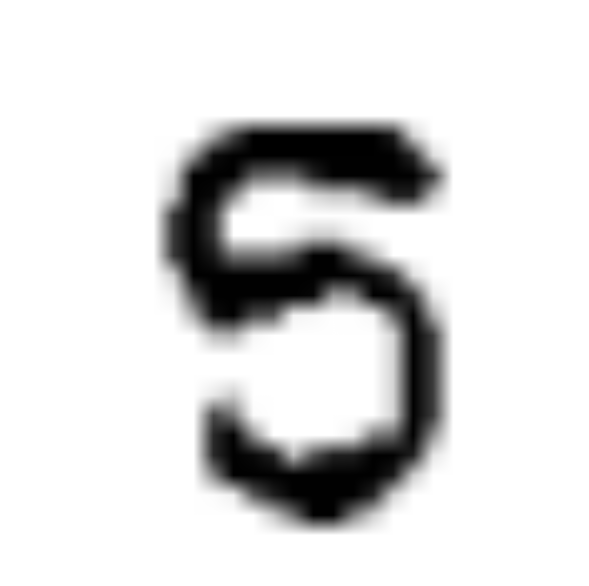

In [16]:
#select random image
idx = np.random.randint(0, x_test.shape[0], (1,))
data = x_test[idx,:,:,:]

#predict label
pred = model.predict_classes(data)

print 'Predicted Class %i' %pred

plt.imshow(data.reshape(num_rows,num_cols), cmap='binary')
plt.axis('off')